# Анализ продаж видеоигр для магазина "Стримчик"
## Общее описание:
Нужно выявить определяющие успешность продаж игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br>
Обозначения:<br>
Name — название игры<br>
Platform — платформа<br>
Year_of_Release — год выпуска<br>
Genre — жанр игры<br>
NA_sales — продажи в Северной Америке (миллионы проданных копий)<br>
EU_sales — продажи в Европе (миллионы проданных копий)<br>
JP_sales — продажи в Японии (миллионы проданных копий)<br>
Other_sales — продажи в других странах (миллионы проданных копий)<br>
Critic_Score — оценка критиков (максимум 100)<br>
User_Score — оценка пользователей (максимум 10)<br>
Rating — рейтинг от организации ESRB.


In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import math 
import scipy.stats as st
game_data = pd.read_csv('/datasets/games.csv')
game_data.info()
print(game_data.duplicated().value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
False    16715
dtype: int64


Наблюдаем, что существует список из 16715 игр, два названия игр пропущены, предлагается дропнуть данные значение, на результат анализа они повлиять не могут. Аналогично предлагается поступить с пропущенными данными по годам, потери составят в районе 1,6%. Дубликаты отсутствуют. Оценка пользователей в данный момент явлется типом object, необходимо заменить на float64. В остальном, критических замечаний по датасету нет. 

In [2]:
game_data.columns = game_data.columns.str.lower()
game_data = game_data[game_data['name'].notna()]#дропаем 2 игры без значений
game_data = game_data[game_data['year_of_release'].notna()] #дропаем игры без указанного года выпуска
game_data = game_data.reset_index(drop = True)#обновляем индекс после удаления
game_data['year_of_release'] = game_data['year_of_release'].astype('int')#приводим год выпуска игры в целочисленный тип
game_data['user_score'] = game_data['user_score'].replace('tbd', np.nan) # tbd означает что рейтинг ожидает присвоения. Поскольку мы не дождались, меняем тип на NaN.
game_data['user_score'] = game_data['user_score'].astype('float')# приводим тип данных object к типу float64
game_data['total_sales'] = game_data ['na_sales'] + game_data ['eu_sales'] + game_data ['jp_sales'] + game_data ['other_sales'] # находим общую сумму продажи и сохраняем в столбец total_sales
game_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
total_sales        16444 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


Приводим названия столбцов к нижнему регистру, очищаем данные от пропущенных значений. Пропущенные значения в оценках критиков, игроков и возрастной рейтинг заполнить не представляется возможным, поскольку ни жанр, ни платформа, ни год выпуска не могут нам подсказать данные показатели. Иные способы заполнения могут привести к существенном искажению анализа. 

## Анализ данных


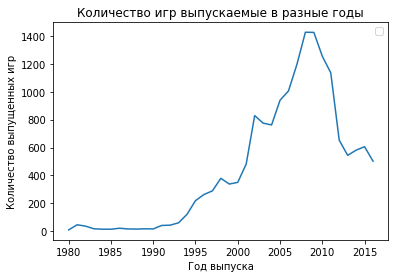

In [3]:
game_on_years = game_data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count') #строим таблицу по количеству выпущенных игр по годам
game_on_years
sns.lineplot(data = game_on_years)
plt.title("Количество игр выпускаемые в разные годы")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.legend('')
plt.show()


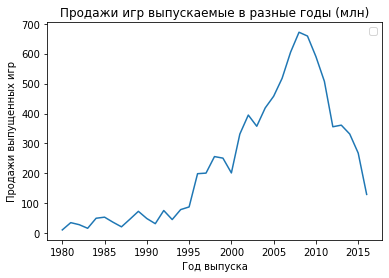

In [4]:
sales_on_years = game_data.pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum') #строим таблицу по количеству выпущенных игр по годам
sns.lineplot(data = sales_on_years)
plt.title("Продажи игр выпускаемые в разные годы (млн)")
plt.xlabel("Год выпуска")
plt.ylabel("Продажи выпущенных игр")
plt.legend('')
plt.show()

Наблюдаем, что бурный рост произовдства и продаж игр приходится на 1995 - 2008 годы на него мог повлиять появление доступной системы PSone которая стоила дешевле конкурентов, при этом не уступая в остальных показателях. Отличные продажи консоли повлекли за собой бум разработки видеоигр, PS2 смогла перекрыть успех первой консоли и была популярна на рынке Латинской Америки вплоть до середены 2010-х годов. На резкий спад могут влиять многие факторы: как мировой финансовый кризис, так и переориентирование разработчиков на мобильный рынок игр.

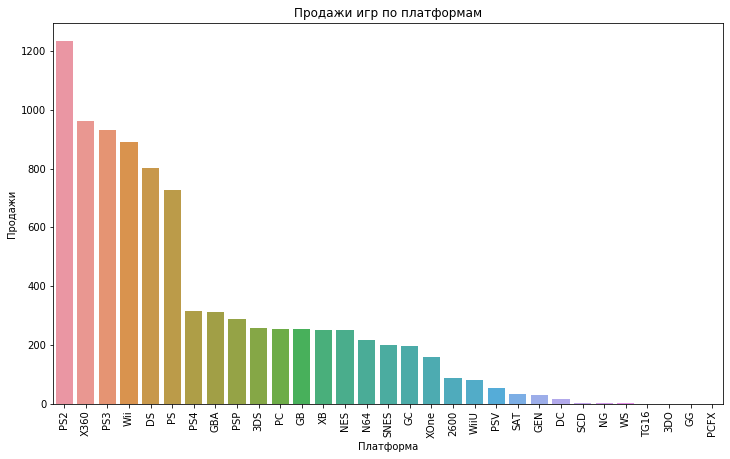

In [5]:
platforms_game_data = game_data.pivot_table(index = 'platform', values ='total_sales', aggfunc = 'sum').sort_values(by='total_sales', ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x=platforms_game_data.index, y=platforms_game_data['total_sales'])
plt.title("Продажи игр по платформам")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.xticks(rotation = 90)
plt.show()

Наблюдаем лидеров в индустрии за время с 1980го года. Сущетсвенно выделяются 6 лидеров: PS2, Xbox 360, PS3, Wii, DS, PSone.
Для анализа данные показатели использовать нельзя, так как PS2, Wii, DS и тем более PS one к 2016 году потеряли свою актуальность. Нужно пронаблюдать жизненные циклы платформ, чтобы найти период за который мы будем аналзировать продажи.

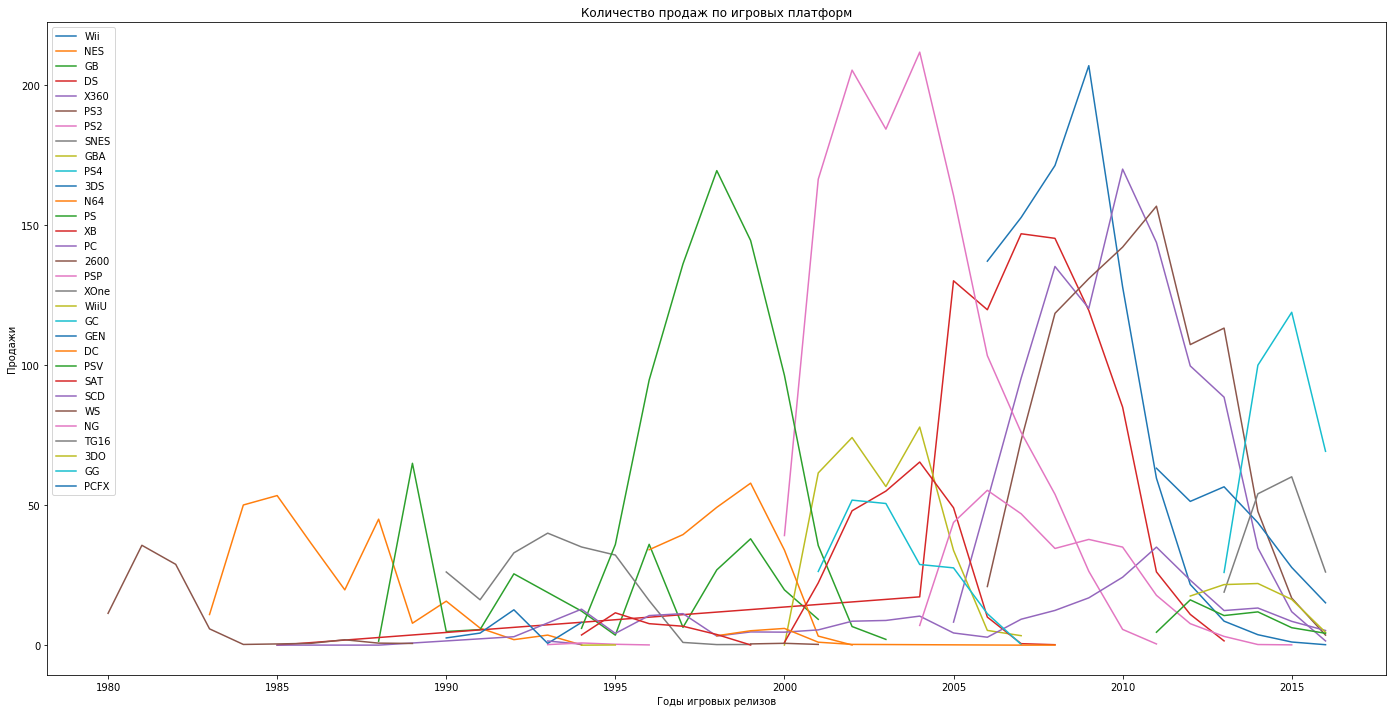

In [6]:
#platforms_year_game_data = game_data.pivot_table(index = ['platform','year_of_release'], values ='name', aggfunc = 'count')
def year_total_sale_for_platform(name, data):
    slice1 = data[(data['platform'] == name)]
    total = slice1.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').sort_values('year_of_release', ascending=False)
    return total

plt.figure(figsize=(24,12))
plt.title('Количество продаж по игровых платформ')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')
for i in list(game_data['platform'].unique()):
    sns.lineplot(data=year_total_sale_for_platform(i, game_data)['total_sales'], label=i)
    plt.legend()

Наблюдаем, что платофрмы живут в среднем по 10 лет, пик продаж приходится на середину цикла платформы. В связи с этим выделяем период 2006-2016 годы

In [7]:
game_data_good = game_data.query('year_of_release > 2005') #выделяем игры с актуальным периодом
game_data_good

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16438,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16440,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16441,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


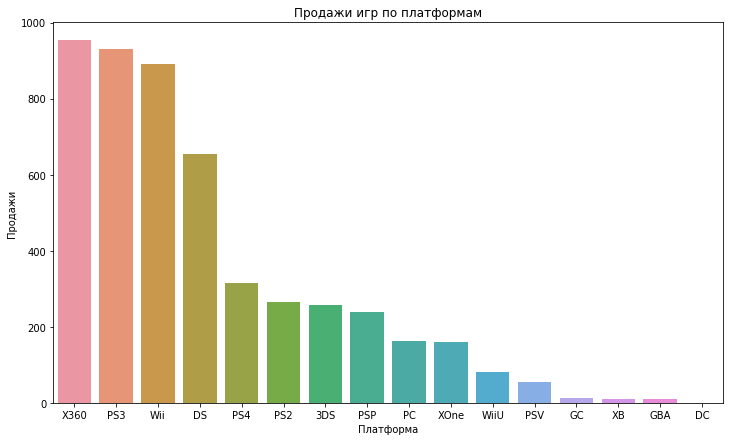

In [8]:
platform_game_data_good = game_data_good.pivot_table(index = 'platform', values ='total_sales', aggfunc = 'sum').sort_values(by='total_sales', ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x=platform_game_data_good.index, y=platform_game_data_good['total_sales'])
plt.title("Продажи игр по платформам")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.show()

На графике продаж за период 2006-2016 можно выделить 5 лидеров: Xbox 360, PS3, Wii, DS, PS4. 

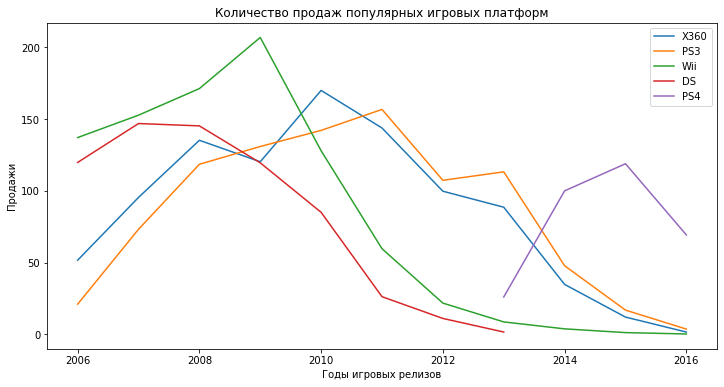

In [9]:
top5_platform = platform_game_data_good.head(5)

plt.figure(figsize=(12,6))
plt.title('Количество продаж популярных игровых платформ')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')
for i in list(top5_platform.index):
    sns.lineplot(data=year_total_sale_for_platform(i, game_data_good)['total_sales'], label=i)
    plt.legend()


Наши ранее произведенные наблюдения подтверждаются и здесь: пик продаж по лидерам последних 10 лет приходится на середину жизненного цикла платформ. Графики продаж у всех вполне сбалансированные, однако график WII имеет как более высокий пик, так и более резкое падение - это может означать быстрыю потерю интереса к казуальным играм. Отсутствие WiiU в лидерах подтверждает данную гипотезу. К 2016 году показатели лидеров десятилетия стремятся к нулю, кроме актуальной PS4. Возьмем дату релиза нового поколения консолей за актуальную.

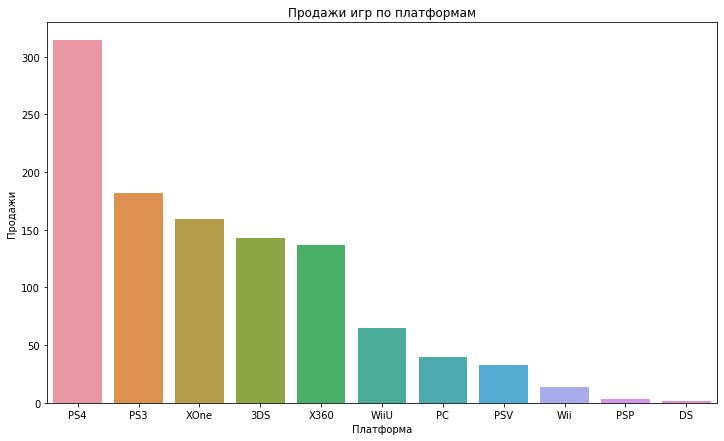

In [10]:
game_data_actual = game_data.query('year_of_release > 2012') #выделяем игры с актуальным периодом
platform_game_data_actual = game_data_actual.pivot_table(index = 'platform', values ='total_sales', aggfunc = 'sum').sort_values(by='total_sales', ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x=platform_game_data_actual.index, y=platform_game_data_actual['total_sales'])
plt.title("Продажи игр по платформам")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.show()

На графике продаж игр за период с 2013 по 2016 наблюдаем, что с сильным отрывом лидирует PS4, PS3 еще остается в лидерах, в топе-3 дебютирует Xbox One. Выделяем 5 лидеров продаж и продолжим анализировать данные по ним. Поялвение в лидерах акутальных консолей: PS4, Xbox One и 3Ds подсказывает, что период для анализа выбран верный.

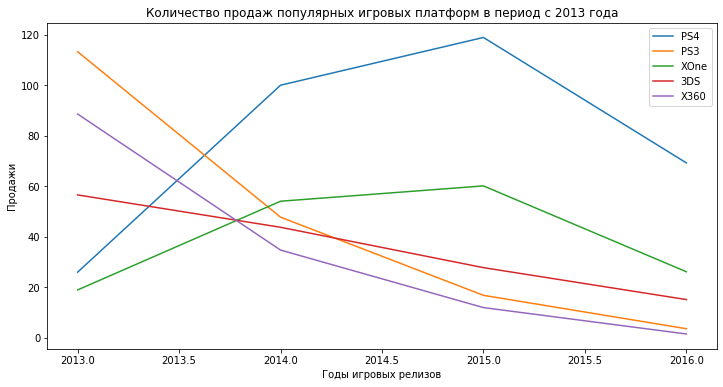

In [11]:
top5_platform_actual = platform_game_data_actual.head(5)

plt.figure(figsize=(12,6))
plt.title('Количество продаж популярных игровых платформ в период с 2013 года')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')
for i in list(top5_platform_actual.index):
    sns.lineplot(data=year_total_sale_for_platform(i, game_data_actual)['total_sales'], label=i)
    plt.legend()

Наблюдаем, что "старички" PS3 и Xbox 360 еще продаются и даже входят в топ-5. Продажи всех платформ падают. Наиболее продающие в 2016 году - это XONE и PS4.

Text(0, 0.5, 'Глобальные продажи')

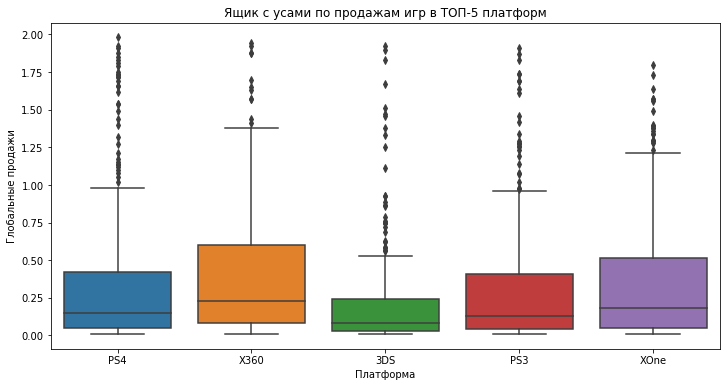

In [12]:
top_5_platforms = game_data_actual[game_data_actual['platform'].isin(['PS4','PS3','XOne','3DS','X360'])]
#top_5_platforms.boxplot(column = 'total_sales')# наблюдаем, что значения выше 2 млн копий являются выбросами
top_5_platforms = top_5_platforms[top_5_platforms['total_sales'] < 2]
plt.figure(figsize=(12,6))
sns.boxplot(data=top_5_platforms, x='platform', y='total_sales')
plt.title('Ящик с усами по продажам игр в ТОП-5 платформ')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')

Наблюдаем, что для всех платформ характерно большое количество выбросов, но большинство игр продаются тиражами в районе 250 тысяч экземпляров. Ящики с усами для Xbox One и Xbox 360 выглядят похоже: 99.3% значений находтся в пределых 1 млн 300 тысяч продаж. Показатели PS4 и PS3: 99.3% значений находится в пределах 1 млн продаж, при этом характерно бОльшее число выбросов: отдельных игр, которые выстреливают. 3Ds выделяется еще больше на фоне конкурентов: 99.3% значений в районе 600 тысяч копий, и еще бОльшее количество выбросов.

                 year_of_release  na_sales  eu_sales  jp_sales  other_sales  \
year_of_release         1.000000 -0.248961 -0.208306 -0.060993    -0.234796   
na_sales               -0.248961  1.000000  0.785362  0.472981     0.944259   
eu_sales               -0.208306  0.785362  1.000000  0.464563     0.944698   
jp_sales               -0.060993  0.472981  0.464563  1.000000     0.496467   
other_sales            -0.234796  0.944259  0.944698  0.496467     1.000000   
critic_score           -0.021142  0.415008  0.346720  0.322358     0.409191   
user_score              0.152447 -0.020933 -0.048925  0.171332    -0.035639   
total_sales            -0.235032  0.928160  0.958157  0.527129     0.998051   

                 critic_score  user_score  total_sales  
year_of_release     -0.021142    0.152447    -0.235032  
na_sales             0.415008   -0.020933     0.928160  
eu_sales             0.346720   -0.048925     0.958157  
jp_sales             0.322358    0.171332     0.527129  
oth

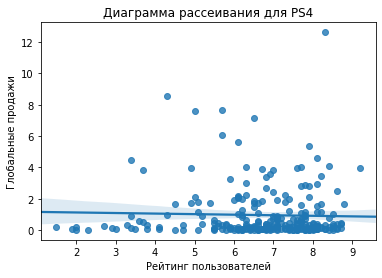

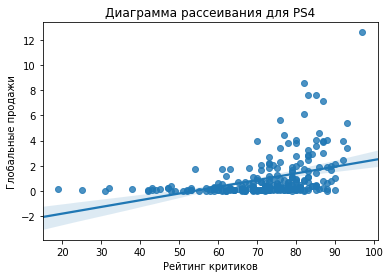

In [13]:
ps4_data = game_data_actual[game_data_actual['platform'].isin(['PS4'])]
print (ps4_data.corr())
sns.regplot(x=ps4_data["user_score"], y=ps4_data["total_sales"])
plt.title('Диаграмма рассеивания для PS4')
plt.xlabel('Рейтинг пользователей',)
plt.ylabel('Глобальные продажи')
plt.show()
sns.regplot(x=ps4_data["critic_score"], y=ps4_data["total_sales"])
plt.title('Диаграмма рассеивания для PS4')
plt.xlabel('Рейтинг критиков',)
plt.ylabel('Глобальные продажи')
plt.show()

Наблюдаем, что продажи на PS4 имеют незначительную отрицательную корреляцию с оценкой у пользователей и среднюю корреляцию с оценкой критиков.

Диаграммы рассеивания для PS3


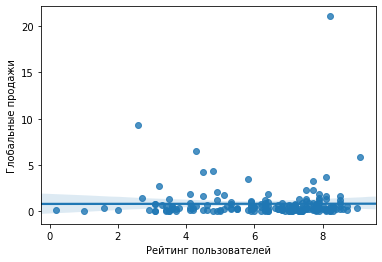

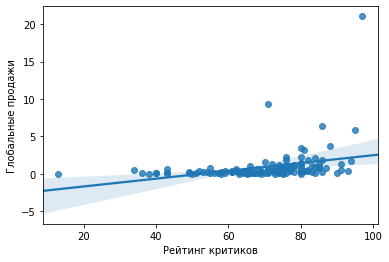

Корреляция для пользовательской оценки PS3 : 0.0023944027357566925
Корреляция для оценки критиков PS3 : 0.3342853393371919
 
Диаграммы рассеивания для XOne


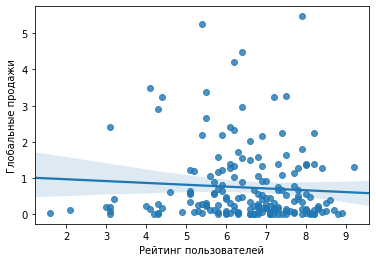

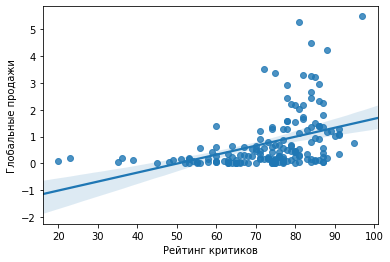

Корреляция для пользовательской оценки XOne : -0.06892505328279414
Корреляция для оценки критиков XOne : 0.4169983280084017
 
Диаграммы рассеивания для 3DS


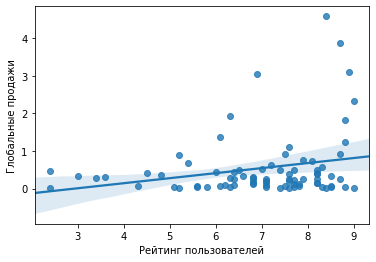

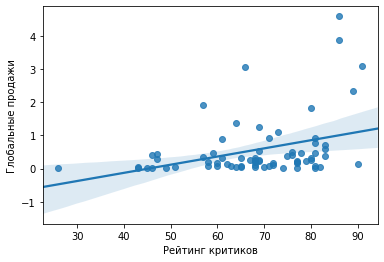

Корреляция для пользовательской оценки 3DS : 0.24150411773563016
Корреляция для оценки критиков 3DS : 0.3570566142288103
 
Диаграммы рассеивания для X360


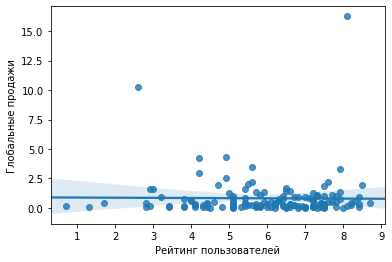

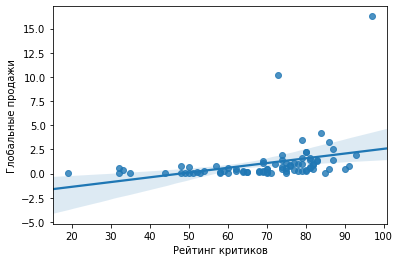

Корреляция для пользовательской оценки X360 : -0.011742185147181342
Корреляция для оценки критиков X360 : 0.3503445460228664
 


In [14]:

def platform_corr(name_platform):#строим функцию для автоматического построения графиков рассеивания для оставшихся платформ
    platform = game_data_actual[game_data_actual['platform']==name_platform]
    print('Диаграммы рассеивания для', name_platform)
    sns.regplot(x='user_score', y='total_sales', data=platform)
    plt.xlabel('Рейтинг пользователей')
    plt.ylabel('Глобальные продажи')
    plt.show()
    sns.regplot(x='critic_score', y='total_sales', data=platform)
    plt.xlabel('Рейтинг критиков')
    plt.ylabel('Глобальные продажи')
    plt.show()
    print('Корреляция для пользовательской оценки', name_platform, ':', platform['user_score'].corr(platform['total_sales']))
    print('Корреляция для оценки критиков', name_platform, ':', platform['critic_score'].corr(platform['total_sales']))
    print(" ")
for i in list(['PS3','XOne','3DS','X360']):
    platform_corr(i)
    

Наблюдаем, что продажи на других платформах имеют незначительную корреляцию (отрицательную или положительную) с оценкой у пользователей и среднюю корреляцию с оценкой критиков. Nintendo 3DS является исключением, здесь оценка пользователей положительно коррелирует с продажами.

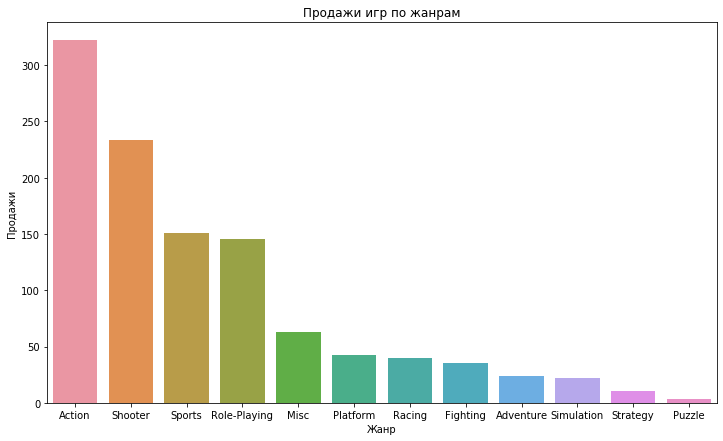

In [15]:
genre_sales = game_data_actual.pivot_table(index = 'genre',values = 'total_sales',
                                           aggfunc = 'sum').sort_values(by='total_sales',
                                                                        ascending=False) #строим таблицу по жанрам
plt.figure(figsize=(12,7))
sns.barplot(x=genre_sales.index, y=genre_sales['total_sales'])
plt.title("Продажи игр по жанрам")
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.show()

Исходя из графика, можем выделить лидеров, это: Экшн, шутер, спортивные игры и РПГ.

Вывод по общемировым показателям: были рассмотрены показатели продаж игр по платформам за весь период. Выделен жизненный цикл платформ: 10 лет. Определены лидер продаж за весь период с 1980ого года, определены лидеры за жизненный цикл платформ с 2006 года. Путем анализа продаж выделили актуальный период: с 2013года по 2016год. Были определены лидеры по продажам игр среди платформ и популярные жанры видеоигр. Магазину нужно сорсредоточится на продажах игр для платформ PS4,PS3,XOne,3DS,X360 жанров экшн, шутер, спортивные игры и РПГ. Также была выявлена положительная корреляция между продажами и рейтингом критиков. Рейтинг пользователей оказывается минимальное влияние на продажи на всех платформах из топ-5, кроме 3 Ds, она показывает положительную корреляцию между рейтингом пользователей и продажами.

## Анализ портрета игрока по регионам.

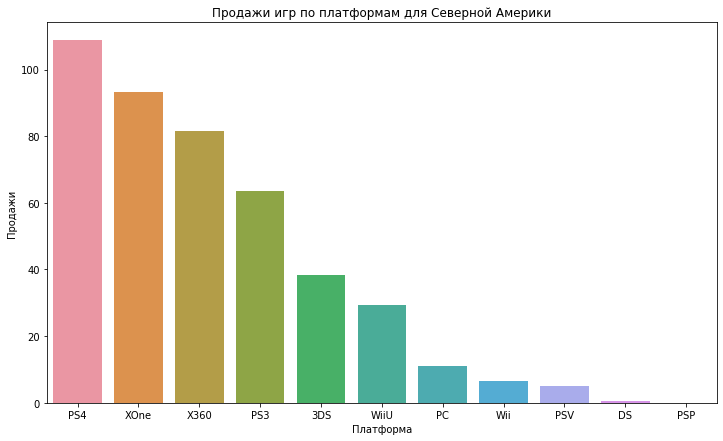

In [16]:
platform_game_data_actual_na = game_data_actual.pivot_table(index = 'platform', values ='na_sales', aggfunc = 'sum').sort_values(by='na_sales', ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x=platform_game_data_actual_na.index, y=platform_game_data_actual_na['na_sales'])
plt.title("Продажи игр по платформам для Северной Америки")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.show()

В Северной Америке, в сравнении с мировыми показателями, популярнее консоли американского же производства - Xbox 360 и Xbox One. Однако, на первом месте остается PS4. Список топ-5 платформ не изменился.

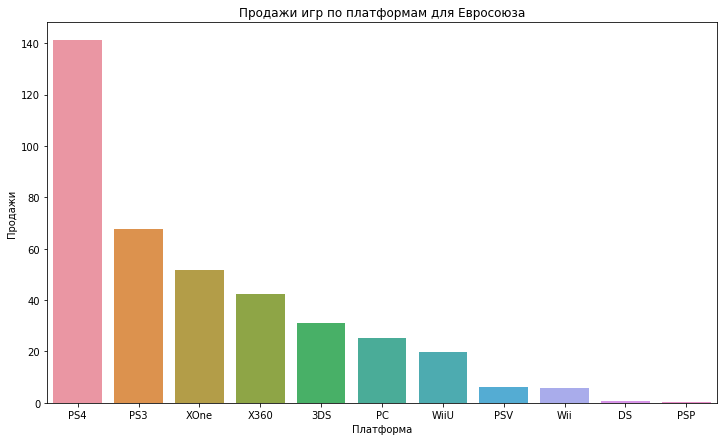

In [17]:
platform_game_data_actual_eu = game_data_actual.pivot_table(index = 'platform', values ='eu_sales', aggfunc = 'sum').sort_values(by='eu_sales', ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x=platform_game_data_actual_eu.index, y=platform_game_data_actual_eu['eu_sales'])
plt.title("Продажи игр по платформам для Евросоюза")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.show()

Список топ-5 платформ для Евросоюза также не изменился, одна преимущество PS4 выражено еще более явно. Из интересного - заметная доля продаж для ПК.

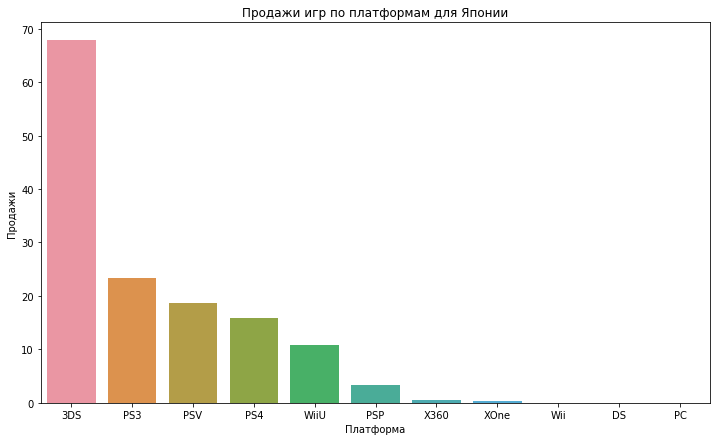

In [18]:
platform_game_data_actual_jp = game_data_actual.pivot_table(index = 'platform', values ='jp_sales', aggfunc = 'sum').sort_values(by='jp_sales', ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x=platform_game_data_actual_jp.index, y=platform_game_data_actual_jp['jp_sales'])
plt.title("Продажи игр по платформам для Японии")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.show()

Исходя из данных продаж игр по японскому рынку, наблюдается абсолютная гегемония японских производителей: Sony и Nintendo. Абсолютный лидер по продажам - 3DS, все еще популярна PS3. Очень популярны портативные системы в сравнении с мировыми показателями: 3DS, PS vita, PSP.

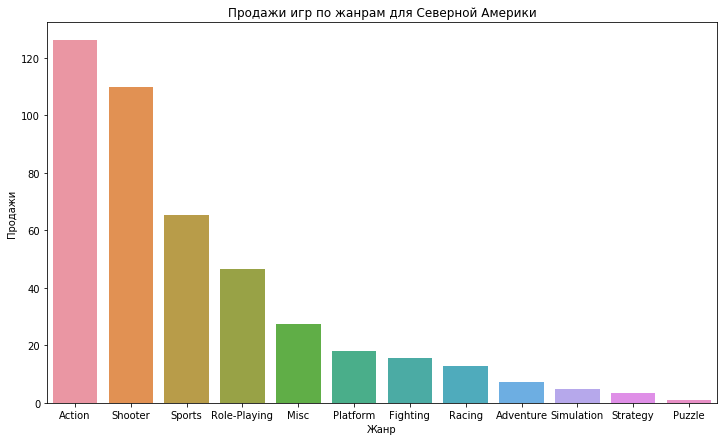

In [19]:
genre_sales_na = game_data_actual.pivot_table(index = 'genre',values = 'na_sales',
                                           aggfunc = 'sum').sort_values(by='na_sales',
                                                                        ascending=False) 
plt.figure(figsize=(12,7))
sns.barplot(x=genre_sales_na.index, y=genre_sales_na['na_sales'])
plt.title("Продажи игр по жанрам для Северной Америки")
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.show()

Топ-5 игр по продажам по жанрам для Северной Америки не отличается от общемирового: Экшн, шутер, спортивные игры, РПГ и игры смешанного жанра.

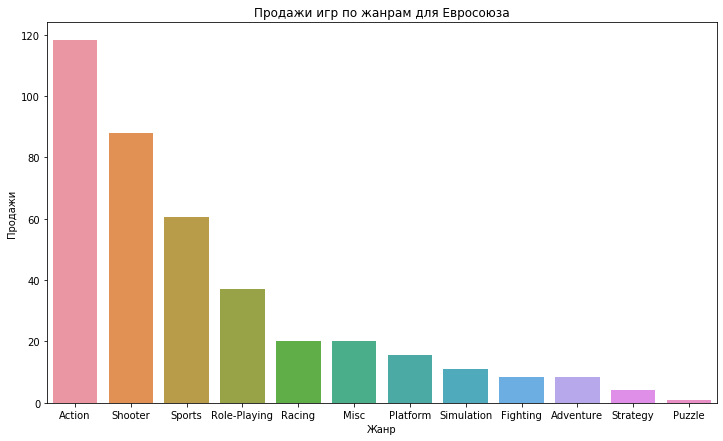

In [20]:
genre_sales_eu = game_data_actual.pivot_table(index = 'genre',values = 'eu_sales',
                                           aggfunc = 'sum').sort_values(by='eu_sales',
                                                                        ascending=False) 
plt.figure(figsize=(12,7))
sns.barplot(x=genre_sales_eu.index, y=genre_sales_eu['eu_sales'])
plt.title("Продажи игр по жанрам для Евросоюза")
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.show()

Топ-5 игр по продажам по жанрам для Евросоюза в целом повторяет общемировой, однако, в топ-5 попадают гоночные игры.

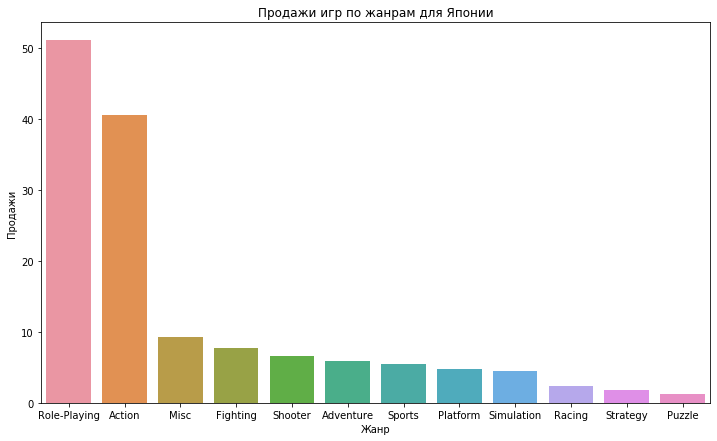

In [21]:
genre_sales_jp = game_data_actual.pivot_table(index = 'genre',values = 'jp_sales',
                                           aggfunc = 'sum').sort_values(by='jp_sales',
                                                                        ascending=False) 
plt.figure(figsize=(12,7))
sns.barplot(x=genre_sales_jp.index, y=genre_sales_jp['jp_sales'])
plt.title("Продажи игр по жанрам для Японии")
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.show()

Топ-5 жанров по продажам в Японии опять же сильно отличается от общемирового:шутеры лишь на пятом месте, в топе дебютируют файтинги на 4ом месте. Экшн второй по популярности жанр, лидер по продажам - РПГ. Здесь скорее всего сыграла традиционная приверженность японцев к жанру Jrpg. Файтинги могли появиться в лидерах из-за того, что я пония является родиной многих боевых искусств.

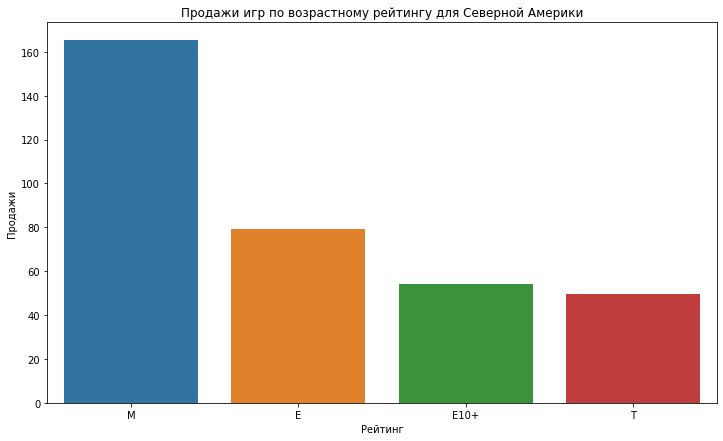

In [22]:
rating_sales_na = game_data_actual.pivot_table(index = 'rating',values = 'na_sales',
                                           aggfunc = 'sum').sort_values(by='na_sales',
                                                                        ascending=False) 
plt.figure(figsize=(12,7))
sns.barplot(x=rating_sales_na.index, y=rating_sales_na['na_sales'])
plt.title("Продажи игр по возрастному рейтингу для Северной Америки")
plt.xlabel("Рейтинг")
plt.ylabel("Продажи")
plt.show()

Самые продающиеся игры для Северной Америки - M. С вдвое худшими результатом продаются игры рейтинга E. E 10+ и Teen продаются с почти одинаковым результатом.

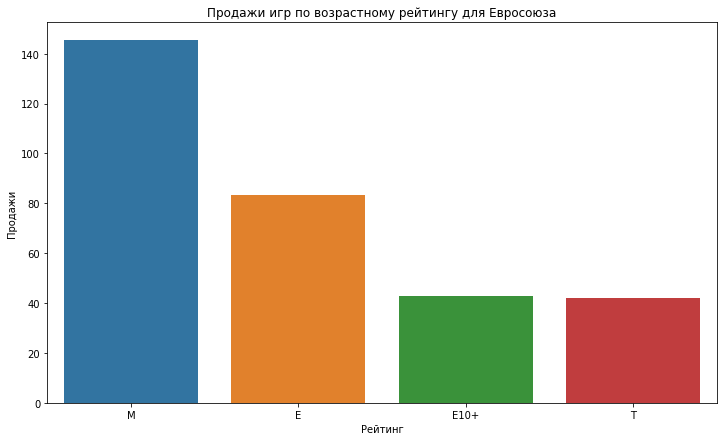

In [23]:
rating_sales_eu = game_data_actual.pivot_table(index = 'rating',values = 'eu_sales',
                                           aggfunc = 'sum').sort_values(by='eu_sales',
                                                                        ascending=False) #строим таблицу по жанрам
plt.figure(figsize=(12,7))
sns.barplot(x=rating_sales_eu.index, y=rating_sales_eu['eu_sales'])
plt.title("Продажи игр по возрастному рейтингу для Евросоюза")
plt.xlabel("Рейтинг")
plt.ylabel("Продажи")
plt.show()

Самые продающиеся игры для Евросоюза - M. С почти вдвое худшими результатом продаются игры рейтинга E. E 10+ и Teen продаются с почти одинаковым результатом.

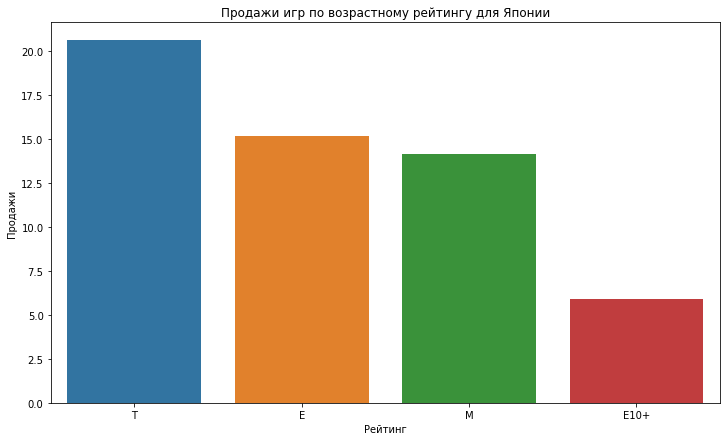

In [24]:
rating_sales_jp = game_data_actual.pivot_table(index = 'rating',values = 'jp_sales',
                                           aggfunc = 'sum').sort_values(by='jp_sales',
                                                                        ascending=False) #строим таблицу по жанрам
plt.figure(figsize=(12,7))
sns.barplot(x=rating_sales_jp.index, y=rating_sales_jp['jp_sales'])
plt.title("Продажи игр по возрастному рейтингу для Японии")
plt.xlabel("Рейтинг")
plt.ylabel("Продажи")
plt.show()

Япония здесь опять показывает свою уникальность: самые популярные игры с рейтингом T, далее идут Е и М.

Вывод по регионам: В Северной Америке и Евросоюзе показатели по продажам близки к общемировым: популярны те же жанры и те же возрастные рейтинги. В Европу лучше завозить больше гонок, чем в среднем по миру. В америку следует завозить больше игр для платформ компании Майкрософт: Xbox 360 и Xbox One. В Японии следует уделять повышенное внимание портативным платформам и играм с рейтингом Т жанра РПГ.

## Проверка гипотез
Гипотеза №1
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.


Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются


In [25]:
xone_user_rating = game_data_actual[(game_data_actual['platform']=='XOne')]['user_score']
pc_user_rating = game_data_actual[(game_data_actual['platform']=='PC')]['user_score']
print('Средний пользовательский рейтинг для Xbox One:', xone_user_rating.mean())
print('Средний пользовательский рейтинг для PC:', pc_user_rating.mean())

Средний пользовательский рейтинг для Xbox One: 6.521428571428572
Средний пользовательский рейтинг для PC: 6.269677419354839


In [26]:
alpha = .01 #статистическую значимость устанавливаем на уровне 1%

results = st.ttest_ind(xone_user_rating.dropna(), pc_user_rating.dropna(), equal_var=False)#проводим независимый т-тест, зная что дисперсия отличается, параменту equal_var присваимваем значение False

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


По результатам т-теста не получилось отвергнуть нулевую гипотезу, соответственно с большой долей вероятности заключаем, что средние рейтинги для PC и Xone не отличаются. Средние значения рейтинга несущественно отличаются.

Гипотеза №2 Средние пользовательские рейтинги жанров Action  и Sports  разные

Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports одинаковые
Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports различаются

In [27]:
action_user_rating = game_data_actual[(game_data_actual['genre']=='Action')]['user_score']
sports_user_rating = game_data_actual[(game_data_actual['genre']=='Sports')]['user_score']
print('Средний пользовательский рейтинг для игр жанра Action:', action_user_rating.mean())
print('Средний пользовательский рейтинг для игр жанра Sports:', sports_user_rating.mean())

Средний пользовательский рейтинг для игр жанра Action: 6.837532133676093
Средний пользовательский рейтинг для игр жанра Sports: 5.238124999999999


In [28]:
alpha = .01 #статистическую значимость устанавливаем на уровне 1%

results = st.ttest_ind(action_user_rating.dropna(), sports_user_rating.dropna(), equal_var=False)#проводим независимый т-тест, зная что дисперсия отличается, параменту equal_var присваимваем значение False

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


По результатам т-теста отвергаем нулевую гипотезу, соответственно с большой долей вероятности заключаем, что средние рейтинги для игр жанра экшн и спорт отличаются. Средние значения рейтинга существенно отличаются, у Экшн средняя оценца выше на 1,6 балла.

## Общий вывод.
Проведя анализ рынка видеоигр можно сделать следующие выводы: наиболее популярные жанры - это экшн, шутеры, спорт, РПГ. Самый популярые игры рейтинга M - для взрослых. Наибольшее внимание нужно уделять играм на PS4 и Xbox Onе, про PS3 и Xbox 360 также пока рано забывать - их продажи достаточно высоки. В Северной америке следует больше завозить игры на Xbox One и Xbox 360, поскольку они популярнее, чем в среднем по миру. В европе популярны игры в жанре гонки, им стоит уделить на данному рынке повышенное внимание относительно среднемировых. Японский рынок существенно отличается по всем показателям: американские консоли совсем не популярны, абсолютные лидеры: Nintendo 3ds,PS3, PSVita, PS4. В Японии нужно уделять внимание играм рейтинга Т - для подростков, играм для портативных систем в жанре РПГ и файтингам для портативных систем. В результате проведенного теста можно заключить, что рейтинги пользователей у ПК и Xbox One не отличаются, а рейтинги игр в жанре экшн отличается от спортивных игр. Исходя из средних значений можем сделать преположение, что рейтинг у экшн-игр выше